In [1]:
!pip install -q lightkurve

     |████████████████████████████████| 1.2MB 2.7MB/s 
     |████████████████████████████████| 256kB 18.9MB/s 
     |████████████████████████████████| 6.5MB 16.3MB/s 
     |████████████████████████████████| 25.9MB 167kB/s 
     |████████████████████████████████| 2.6MB 43.3MB/s 
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install regions --no-deps

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for regions: filename=regions-0.4-cp36-cp36m-linux_x86_64.whl size=963185 sha256=222130f05a41c46866e461a833f82e3c08d58cd68388afa6afec863fb8cc51e1
  Stored in directory: /root/.cache/pip/wheels/64/40/0b/b4c2110e9d8fe132da7010597bb1e408bea60ef2a64b5a5058
Successfully built regions


In [134]:
import lightkurve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from regions import read_ds9
import eleanor
%matplotlib inline

### Let's see which contemporaneously-observed K2 and TESS objects exist and sort them by magnitude using the data from Barclay & Barentsen (https://figshare.com/articles/A_catalog_of_stars_observed_simultaneously_by_Kepler_and_TESS/7227260)

In [6]:
targetlist = pd.read_csv('kepler19tess2_crossmatch_v01.csv') 

In [7]:
targetlist

,K2 EPIC,TIC,Gaia ID,RA,Dec,KepMag,Tmag,G,Teff,Radius,Dist,Dist_minus_1_sigma,Dist_plus_1_sigma,Simbad ID,Simbad Type
0,245925582,4554210.0,2.413051e+18,347.998206,-11.933554,7.659,6.676,7.487621,5046.60,9.55,252.608639,249.612716,255.676032,CCDM J23120-1156AB,**
1,245929348,4579916.0,2.413014e+18,348.407601,-11.749342,9.316,8.097,9.015880,4129.65,23.55,701.505145,674.692945,730.491079,HD 219131,Star
2,245931711,4582469.0,2.413392e+18,348.516775,-11.629405,9.944,9.411,9.786786,6296.17,1.18,148.368687,147.278023,149.475332,HD 219191,Star
3,245927251,4520668.0,2.413067e+18,347.867863,-11.852871,10.928,10.513,10.832324,6735.80,1.85,428.703550,420.762378,436.944596,HD 218871,Star
4,245933030,4579787.0,2.413443e+18,348.275732,-11.566588,11.128,10.674,11.108854,5829.00,1.10,214.971223,212.731272,217.257986,TYC 5824-282-1,PM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,251816599,4579843.0,2.413059e+18,348.279026,-11.809766,18.525,18.006,19.636204,NaN,NaN,NaN,NaN,NaN,LEDA 961452,Galaxy
167,251816601,4520629.0,NaN,347.835192,-11.809116,18.567,15.668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,245930077,4579923.0,NaN,348.431760,-11.713218,18.729,16.747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,251816651,NaN,NaN,349.426691,-11.090669,18.952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# going for broke here as an experiment
targetlist[targetlist["Tmag"]>18]

,K2 EPIC,TIC,Gaia ID,RA,Dec,KepMag,Tmag,G,Teff,Radius,Dist,Dist_minus_1_sigma,Dist_plus_1_sigma,Simbad ID,Simbad Type
146,245925909,4554205.0,2.413051e+18,348.000306,-11.917110,17.429,18.134,19.794857,NaN,NaN,829.192797,530.080216,1492.585927,NaN,NaN
154,245943851,49531827.0,2.413534e+18,349.492911,-11.062160,17.748,18.291,19.799990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,245938596,4611199.0,2.413430e+18,349.085099,-11.291329,18.257,18.437,19.725208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,245937809,4602767.0,2.413427e+18,348.896881,-11.330567,18.312,18.049,20.059874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,245930321,404244674.0,NaN,348.161796,-11.700896,18.340,18.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,251816599,4579843.0,2.413059e+18,348.279026,-11.809766,18.525,18.006,19.636204,NaN,NaN,NaN,NaN,NaN,LEDA 961452,Galaxy


## Determine which objects have lightcurves in both K2 and TESS:

In [90]:
for idx, obj in enumerate(targetlist['TIC'][targetlist["Tmag"]>10]):
    query = "TIC " + str(int(targetlist['TIC'][targetlist["Tmag"]>10].values[idx]))
    result = lightkurve.search.search_lightcurvefile(query, mission='TESS')
    if len(result) == 0:
        print('Nothing found.')
    else: 
        print("Success: ", query)

No data found for target "TIC 4520668".


Nothing found.


No data found for target "TIC 4579787".


Nothing found.


No data found for target "TIC 404244638".


Nothing found.


No data found for target "TIC 4619629".


Nothing found.


No data found for target "TIC 5738944".


Nothing found.


No data found for target "TIC 4582572".


Nothing found.


No data found for target "TIC 4520658".


Nothing found.


No data found for target "TIC 4582457".


Nothing found.


No data found for target "TIC 404244647".


Nothing found.


No data found for target "TIC 5741465".


Nothing found.


No data found for target "TIC 4554186".


Nothing found.


No data found for target "TIC 4611188".


Nothing found.


No data found for target "TIC 404244634".


Nothing found.


No data found for target "TIC 4520626".


Nothing found.


No data found for target "TIC 4602734".


Nothing found.


No data found for target "TIC 4579816".


Nothing found.


No data found for target "TIC 4602774".


Nothing found.


No data found for target "TIC 49529599".


Nothing found.


No data found for target "TIC 4520619".


Nothing found.


No data found for target "TIC 5741463".


Nothing found.


No data found for target "TIC 4579789".


Nothing found.


No data found for target "TIC 5738973".


Nothing found.


No data found for target "TIC 4520664".


Nothing found.


No data found for target "TIC 4582435".


Nothing found.


No data found for target "TIC 4520692".


Nothing found.


No data found for target "TIC 4579913".


Nothing found.


No data found for target "TIC 4582581".


Nothing found.


No data found for target "TIC 5738968".


Nothing found.


No data found for target "TIC 4582629".


Nothing found.


No data found for target "TIC 4582465".


Nothing found.


No data found for target "TIC 404244692".


Nothing found.


No data found for target "TIC 4579839".


Nothing found.


No data found for target "TIC 4602562".


Nothing found.


No data found for target "TIC 404244672".


Nothing found.


No data found for target "TIC 5725844".


Nothing found.


No data found for target "TIC 4582614".


Nothing found.


No data found for target "TIC 404244659".


Nothing found.


No data found for target "TIC 4602719".


Nothing found.


No data found for target "TIC 4579899".


Nothing found.


No data found for target "TIC 5738955".


Nothing found.


No data found for target "TIC 4582637".


Nothing found.


No data found for target "TIC 5738957".


Nothing found.


No data found for target "TIC 4619621".


Nothing found.


No data found for target "TIC 49554720".


Nothing found.


No data found for target "TIC 4611179".


Nothing found.
Success:  TIC 404244688


No data found for target "TIC 404244658".


Nothing found.


No data found for target "TIC 4579919".


Nothing found.


No data found for target "TIC 4602758".


Nothing found.


No data found for target "TIC 4579811".


Nothing found.


No data found for target "TIC 4579788".


Nothing found.


No data found for target "TIC 4579809".


Nothing found.


No data found for target "TIC 5725852".


Nothing found.


No data found for target "TIC 4602768".


Nothing found.


No data found for target "TIC 4619633".


Nothing found.


No data found for target "TIC 4554166".


Nothing found.


No data found for target "TIC 4602722".


Nothing found.


No data found for target "TIC 4579948".


Nothing found.


No data found for target "TIC 49529598".


Nothing found.


No data found for target "TIC 4602731".


Nothing found.


No data found for target "TIC 404244636".


Nothing found.


No data found for target "TIC 4579864".


Nothing found.


No data found for target "TIC 4579851".


Nothing found.


No data found for target "TIC 4520688".


Nothing found.


No data found for target "TIC 4520628".


Nothing found.


No data found for target "TIC 4602527".


Nothing found.


No data found for target "TIC 4610899".


Nothing found.


No data found for target "TIC 4610906".


Nothing found.


No data found for target "TIC 4554170".


Nothing found.


No data found for target "TIC 4579801".


Nothing found.


No data found for target "TIC 4619619".


Nothing found.


No data found for target "TIC 4582433".


Nothing found.


No data found for target "TIC 4579893".


Nothing found.


No data found for target "TIC 4610920".


Nothing found.


No data found for target "TIC 4582596".


Nothing found.


No data found for target "TIC 4602741".


Nothing found.


No data found for target "TIC 4610915".


Nothing found.


No data found for target "TIC 4579807".


Nothing found.


No data found for target "TIC 404244681".


Nothing found.


No data found for target "TIC 4579813".


Nothing found.


No data found for target "TIC 4579963".


Nothing found.


No data found for target "TIC 4610933".


Nothing found.


No data found for target "TIC 4579936".


Nothing found.


No data found for target "TIC 4520701".


Nothing found.


No data found for target "TIC 404244656".


Nothing found.


No data found for target "TIC 4582505".


Nothing found.


No data found for target "TIC 4579825".


Nothing found.


No data found for target "TIC 4579852".


Nothing found.


No data found for target "TIC 4579834".


Nothing found.


No data found for target "TIC 4602757".


Nothing found.


No data found for target "TIC 4582619".


Nothing found.


No data found for target "TIC 4602538".


Nothing found.


No data found for target "TIC 5725835".


Nothing found.


No data found for target "TIC 4579900".


Nothing found.


No data found for target "TIC 404244680".


Nothing found.


No data found for target "TIC 4579939".


Nothing found.


No data found for target "TIC 4582595".


Nothing found.


No data found for target "TIC 4579953".


Nothing found.


No data found for target "TIC 4582476".


Nothing found.


No data found for target "TIC 4579795".


Nothing found.


No data found for target "TIC 4579928".


Nothing found.


No data found for target "TIC 4579929".


Nothing found.


No data found for target "TIC 4582479".


Nothing found.


No data found for target "TIC 4582487".


Nothing found.


No data found for target "TIC 49529597".


Nothing found.


No data found for target "TIC 4520660".


Nothing found.


No data found for target "TIC 5738930".


Nothing found.


No data found for target "TIC 4582442".


Nothing found.


No data found for target "TIC 5738933".


Nothing found.


No data found for target "TIC 4619616".


Nothing found.


No data found for target "TIC 4619635".


Nothing found.


No data found for target "TIC 49531841".


Nothing found.


No data found for target "TIC 5738967".


Nothing found.


No data found for target "TIC 4554174".


Nothing found.


No data found for target "TIC 4520662".


Nothing found.


No data found for target "TIC 4579911".


Nothing found.


No data found for target "TIC 4602511".


Nothing found.


No data found for target "TIC 4520656".


Nothing found.


No data found for target "TIC 4610911".


Nothing found.


No data found for target "TIC 4602728".


Nothing found.


No data found for target "TIC 4582444".


Nothing found.


No data found for target "TIC 4602546".


Nothing found.


No data found for target "TIC 4582459".


Nothing found.


No data found for target "TIC 404244640".


Nothing found.


No data found for target "TIC 5741462".


Nothing found.


No data found for target "TIC 5738963".


Nothing found.


No data found for target "TIC 4554175".


Nothing found.


No data found for target "TIC 4582445".


Nothing found.


No data found for target "TIC 404244673".


Nothing found.


No data found for target "TIC 4520677".


Nothing found.


No data found for target "TIC 4611200".


Nothing found.


No data found for target "TIC 5738942".


Nothing found.


No data found for target "TIC 404244677".


Nothing found.


No data found for target "TIC 4602545".


Nothing found.


No data found for target "TIC 4610924".


Nothing found.


No data found for target "TIC 4582618".


Nothing found.


No data found for target "TIC 4554192".


Nothing found.


No data found for target "TIC 4582639".


Nothing found.


No data found for target "TIC 4520675".


Nothing found.


No data found for target "TIC 5738953".


Nothing found.


No data found for target "TIC 4619642".


Nothing found.


No data found for target "TIC 4579810".


Nothing found.


No data found for target "TIC 5725841".


Nothing found.


No data found for target "TIC 4554205".


Nothing found.


No data found for target "TIC 4520637".


Nothing found.


No data found for target "TIC 5738970".


Nothing found.


No data found for target "TIC 5725832".


Nothing found.


No data found for target "TIC 5725837".


Nothing found.


No data found for target "TIC 4610932".


Nothing found.


No data found for target "TIC 4610935".


Nothing found.


No data found for target "TIC 4602544".


Nothing found.


No data found for target "TIC 49531827".


Nothing found.


No data found for target "TIC 4579817".


Nothing found.


No data found for target "TIC 4579856".


Nothing found.


No data found for target "TIC 4579859".


Nothing found.


No data found for target "TIC 4602521".


Nothing found.


No data found for target "TIC 404244676".


Nothing found.


No data found for target "TIC 4610913".


Nothing found.


No data found for target "TIC 4611199".


Nothing found.


No data found for target "TIC 49529595".


Nothing found.


No data found for target "TIC 4602767".


Nothing found.


No data found for target "TIC 404244674".


Nothing found.


No data found for target "TIC 5738934".


Nothing found.


No data found for target "TIC 4579843".


Nothing found.


No data found for target "TIC 4520629".


Nothing found.


No data found for target "TIC 4579923".


Nothing found.


# Only one object fainter than Tmag = 10!
Looks like TIC 404244688 is our first test-subject.

In [102]:
lightkurve.search.search_lightcurvefile("TIC 404244688")

#,observation,target_name,productFilename,distance
0,K2 Campaign 12,ktwo245931927,ktwo245931927-c12_llc.fits,0.0
1,K2 Campaign 19,ktwo245931927,ktwo245931927-c19_llc.fits,0.0
2,TESS Sector 2,404244688,tess2018234235059-s0002-0000000404244688-0121-s_lc.fits,0.0


### First, the TESS lightcurve:

In [96]:
lcf_tess = lightkurve.search.search_lightcurvefile("TIC 404244688", mission='TESS').download()

In [95]:
lcf_tess

#,observation,target_name,productFilename,distance
0,TESS Sector 2,404244688,tess2018234235059-s0002-0000000404244688-0121-s_lc.fits,0.0


In [97]:
lc = lcf_tess.PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

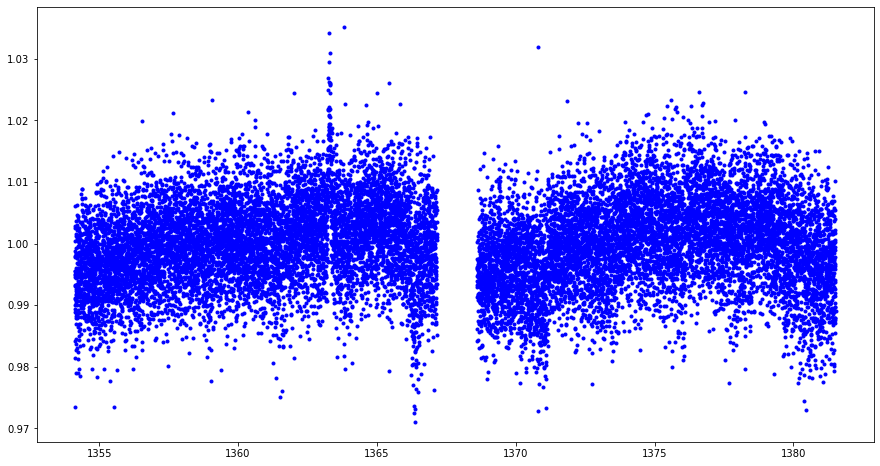

In [99]:
plt.figure(figsize=(15,8))
plt.plot(lc.time, lc.flux, 'b.')

### Now get the corresponding Kepler one:

In [104]:
lcf_k2 = lightkurve.search_lightcurvefile("TIC 404244688", mission='K2', campaign=19).download()

In [106]:
lc_k2 = lcf_k2.PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

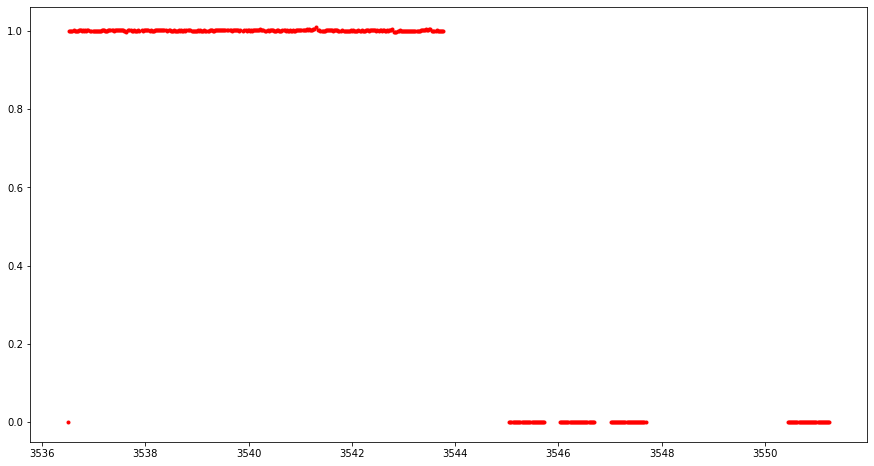

In [107]:
plt.figure(figsize=(15,8))
plt.plot(lc_k2.time, lc_k2.flux, 'r.')

### Plot them together -- not contemporaneous? 

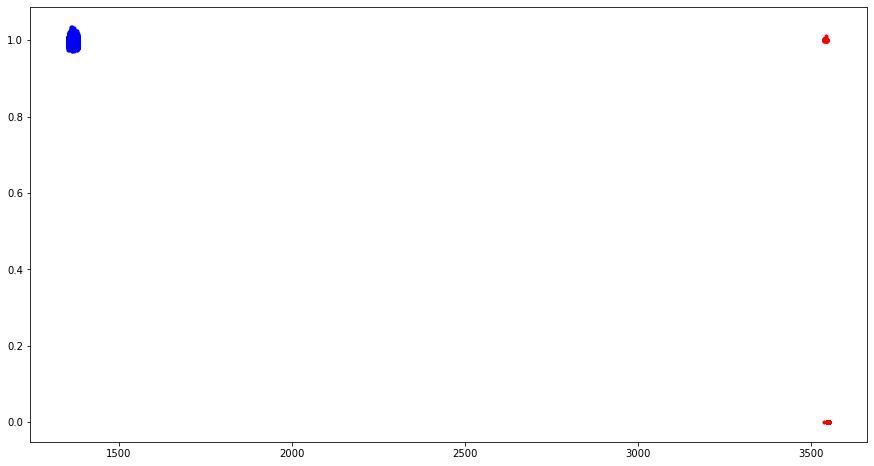

In [108]:
plt.figure(figsize=(15,8))
plt.plot(lc_k2.time, lc_k2.flux, 'r.')
plt.plot(lc.time, lc.flux, 'b.')

### Plot them together by overlaying the normalized datasets on top of each other - NOT CONTEMPORANEOUS

Text(0, 0.5, 'Normalized Flux')

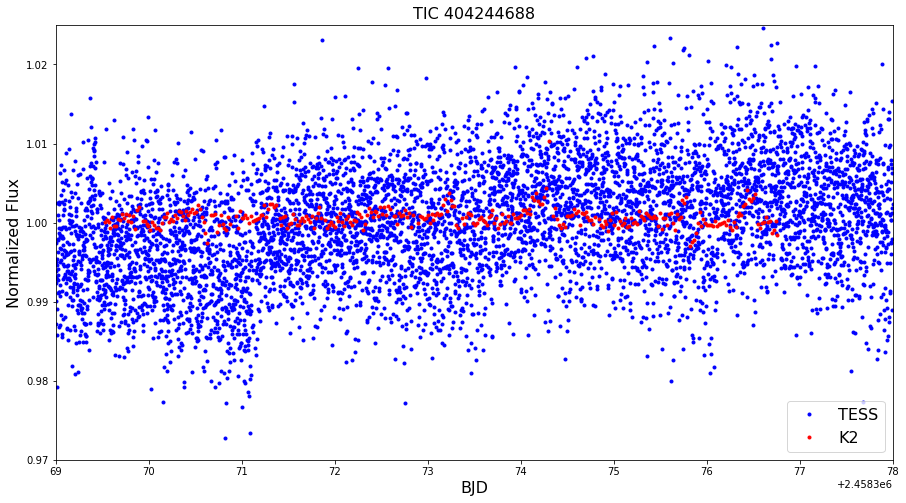

In [142]:
plt.figure(figsize=(15,8))
plt.plot(lc.time + 2457000, lc.flux, 'b.', label='TESS')
plt.plot(lc_k2.time + 2454833, lc_k2.flux, 'r.', label='K2')
plt.xlim(2458369,2458378)
plt.ylim(0.97,1.025)
plt.title('TIC 404244688', fontsize=16)
plt.legend(loc=4, fontsize=16)
plt.xlabel('BJD', fontsize=16)
plt.ylabel('Normalized Flux', fontsize=16)

# More extraction methods: eleanor

In [137]:
star = eleanor.Source(tic=404244688, sector=2)

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  2...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  2 now available.


/Users/kwduong/miniconda3/envs/astroconda/lib/python3.6/site-packages/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")


In [139]:
print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

Found TIC 404244688 (Gaia 2413066803334502016), with TESS magnitude 12.6115, RA 348.175828431504, and Dec -11.6190781243267


In [150]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)#, regressors='corner')

Set MJD-OBS to 58353.609343 from DATE-OBS.
Set DATE-BEG to '2018-08-23T14:38:36.458' from MJD-BEG'. [astropy.wcs.wcs]
100%|██████████| 1245/1245 [00:11<00:00, 107.14it/s]


(0.98, 1.0625)

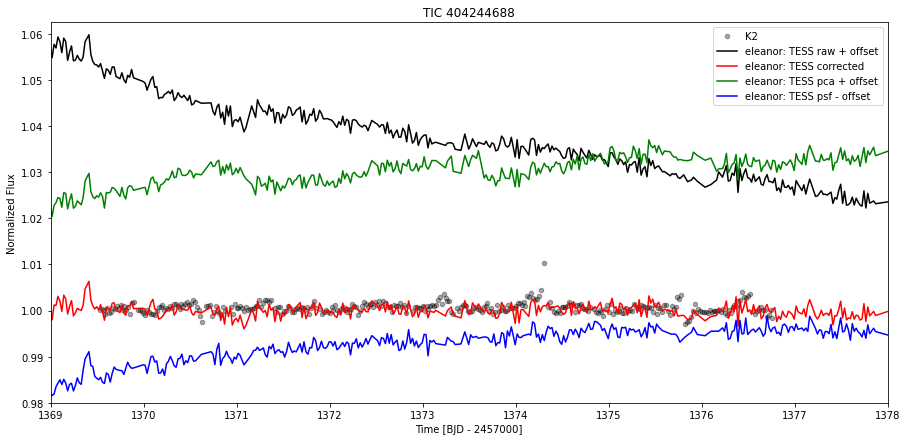

In [172]:
plt.figure(figsize=(15,7))

q = data.quality == 0

plt.plot(lc_k2.time + 2454833 - 2457000, lc_k2.flux, 'k.', alpha=0.35, ms=9, label='K2')

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]) + 0.06, 'k', label='eleanor: TESS raw + offset')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.0, 'r', label='eleanor: TESS corrected')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]) + 0.03, 'g', label='eleanor: TESS pca + offset')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b', label='eleanor: TESS psf - offset')

plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.title('TIC 404244688')
plt.legend(loc=1, fontsize=10)
plt.xlim(2458369-2457000,2458378-2457000)
plt.ylim(0.98,1.0625)

In [186]:
# measure noise in eleanor extraction
np.std((data.corr_flux[q]/np.nanmedian(data.corr_flux[q]))[1:300])

0.0010036102843227106

In [187]:
# measure noise in K2:
np.std(lc_k2.flux[1:300])


0.0011394629

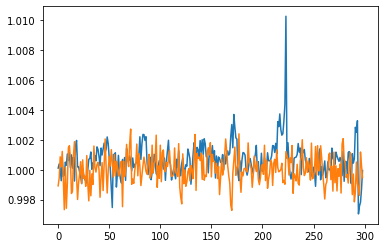

In [184]:
plt.plot(lc_k2.flux[1:300])
plt.plot((data.corr_flux[q]/np.nanmedian(data.corr_flux[q]))[1:300])

In [183]:
(data.corr_flux[q]/np.nanmedian(data.corr_flux[q]))[1]

0.9989215948969706